Some pictures and our coursework title here! Anyone has some ideas plz update here :)

# Introduction

## Background

## Objective

# Set up environment

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import pyspark

number_cores = int(os.environ['NUM_CPUS'])
memory_gb = int(os.environ['AVAILABLE_MEMORY_MB']) // 1024
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .set('spark.driver.memory', '{}g'.format(memory_gb))
)
sc = pyspark.SparkContext(conf=conf)

In [2]:
print(sc)

<SparkContext master=local[4] appName=pyspark-shell>


In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Prepare the dataset

## Scraping

## Load dataset

In [4]:
# Load the dataset
indian = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/data_indian.csv", header = True)
italian = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/data_italian.csv", header = True)
mexican = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/data_mexican.csv", header = True)
new_recipe = sqlContext.read.csv("/project/Project/DataEngineeringGroupAO/Recipe_dataset/final_scrape_not_cleaned.csv", header = True)

In [5]:
# See the size of the dataset
print('indian: ', indian.count(),' italian: ', italian.count(), ' mexican: ', mexican.count(),
     ' new_recipe: ', new_recipe.count())

indian:  480  italian:  400  mexican:  620  new_recipe:  2340


For the first three datasets, we do not have labels for them. We could use them as training set but three of them combined together is not enough. In this case, we decided to combine them together first, and then do splitting, and then remove the labels of training set. So, we have to first label the unlabelled dataset manually, which is shown as below.

In [6]:
# Label the data
from pyspark.sql.functions import lit

indian = indian.withColumn("label",lit("indian"))
italian = italian.withColumn("label",lit("italian"))
mexican = mexican.withColumn("label",lit("mexican"))

In [7]:
# Combine all datasets into one

from functools import reduce
from pyspark.sql import DataFrame

def unionAll(dfs):
    return reduce(DataFrame.unionAll, dfs)

dfs = [indian, italian, mexican, new_recipe]
recipe = unionAll(dfs)
recipe.show()

+--------------------+--------------------+------+
|               Title|         Description| label|
+--------------------+--------------------+------+
|  Indian Peanut Stew|This is an easy, ...|indian|
|        Roomali Roti|There is no leave...|indian|
|Spicy Sweet Potat...|It's important to...|indian|
|        Chicken Saag|The classic India...|indian|
|Paleo Slow Cooker...|Boneless pork loi...|indian|
|Bombay Chicken an...|Chicken parts are...|indian|
|Indian Carrots, P...|Potatoes, peas an...|indian|
|Wendy's Indian Bu...|This recipe resem...|indian|
|    Indian Chickpeas|Garbanzo beans, o...|indian|
|Dal Makhani (Indi...|These richly spic...|indian|
|               Raita|Chopped tomatoes ...|indian|
|Yogurt-Marinated ...|A yogurt-based ma...|indian|
|Indian-Spiced Roa...|Spicy roasted chi...|indian|
|Cauliflower and T...|Pressed tofu cube...|indian|
|Channa Masala (Ch...|This fantastic In...|indian|
|Bengali Chicken C...|Thy this deliciou...|indian|
|  Indian Sweet Bread|A crisp a

As these two scraping are from the same website, but using different method, there might be some duplicates in the combined datasets. We try to remove the duplicates before data cleaning.

In [8]:
# Size before removing duplicates
print(recipe.count())

3840


In [9]:
# Remove duplicates
recipe = recipe.dropDuplicates(["Title"])

In [10]:
# Size after dropping duplicates
print(recipe.count())

3793


# Data Cleaning

Now we come to the data cleaning part! Our dataset is all about **text**, and it needs to be transformed a bit for better analysis.

- Lowercase
- Remove punctuations and digits. 

In NLTK, we have packages which helps remove punctuations and digits, but in our case, we try to use **regular expression** to remove unwanted signs in our dataset.
- Remove stopwords
- Stemming the text 


In [11]:
# import all packages needed for data cleaning

from pyspark.sql.functions import udf, regexp_replace, lower, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import IntegerType, ArrayType, StringType

In [12]:
# Lowercase

recipe = recipe.select(*[lower(col(col_name)).name(col_name) for col_name in recipe.columns])
recipe.show()

+--------------------+--------------------+-------+
|               Title|         Description|  label|
+--------------------+--------------------+-------+
|amanda & graham's...|restaurant in our...|italian|
|avocado and mango...|a wonderfully fru...|mexican|
|batman's best cae...|fast, easy, cream...|italian|
|beef chilli with ...|this is a hearty ...|mexican|
|chicken enchilada...|chicken, sour cre...|mexican|
|chorizo breakfast...|a yummy breakfast...|mexican|
|coconut-coriander...|simple preparatio...| indian|
|coriander chicken...|this chicken dish...|mexican|
|           curd rice|curd rice, or yog...| indian|
|daz's tomato chee...|this is my favour...|italian|
|easy chicken tikk...|a quick and easy ...| indian|
|four seasons ench...|nice and spicy us...|mexican|
|homemade four che...|fresh pasta fille...|italian|
|homemade paneer c...|paneer is a white...| indian|
|      indian khichri|khichri is a very...| indian|
|               kheer|this is a popular...| indian|
| madras pot

In [13]:
# Remove punctuation and digits

recipe_clean = recipe.select(regexp_replace('Title', "[^a-zA-Z\\s]", "").alias('title'), 
    (regexp_replace('Description', "[^a-zA-Z\\s]", "").alias('des')),'label')
recipe_clean.show()

+--------------------+--------------------+-------+
|               title|                 des|  label|
+--------------------+--------------------+-------+
|amanda  grahams m...|restaurant in our...|italian|
|avocado and mango...|a wonderfully fru...|mexican|
|batmans best caes...|fast easy creamy ...|italian|
|beef chilli with ...|this is a hearty ...|mexican|
|chicken enchilada...|chicken sour crea...|mexican|
|chorizo breakfast...|a yummy breakfast...|mexican|
|coconutcoriander ...|simple preparatio...| indian|
|coriander chicken...|this chicken dish...|mexican|
|           curd rice|curd rice or yogh...| indian|
|dazs tomato chees...|this is my favour...|italian|
|easy chicken tikk...|a quick and easy ...| indian|
|four seasons ench...|nice and spicy us...|mexican|
|homemade four che...|fresh pasta fille...|italian|
|homemade paneer c...|paneer is a white...| indian|
|      indian khichri|khichri is a very...| indian|
|               kheer|this is a popular...| indian|
| madras pot

In [14]:
# Remove Stopwords

# Tokenize text
tokenizer = Tokenizer(inputCol = "des", outputCol = "des_token")
recipe = tokenizer.transform(recipe_clean).select('title','des','des_token','label')
# tokenized.select("Description", "Des_words")\
    #.withColumn("tokens", countTokens(col("Des_words"))).show(truncate=False)

# Remove stopwords
remover = StopWordsRemover(inputCol = 'des_token', outputCol = 'des_clean')
recipe_no_stopw = remover.transform(recipe).select('title','des_clean', 'label')
recipe_no_stopw.show()

+--------------------+--------------------+-------+
|               title|           des_clean|  label|
+--------------------+--------------------+-------+
|amanda  grahams m...|[restaurant, livi...|italian|
|avocado and mango...|[wonderfully, fru...|mexican|
|batmans best caes...|[fast, easy, crea...|italian|
|beef chilli with ...|[hearty, deliciou...|mexican|
|chicken enchilada...|[chicken, sour, c...|mexican|
|chorizo breakfast...|[yummy, breakfast...|mexican|
|coconutcoriander ...|[simple, preparat...| indian|
|coriander chicken...|[chicken, dish, d...|mexican|
|           curd rice|[curd, rice, yogh...| indian|
|dazs tomato chees...|[favourite, start...|italian|
|easy chicken tikk...|[quick, easy, cur...| indian|
|four seasons ench...|[nice, spicy, use...|mexican|
|homemade four che...|[fresh, pasta, fi...|italian|
|homemade paneer c...|[paneer, white, c...| indian|
|      indian khichri|[khichri, popular...| indian|
|               kheer|[popular, pakista...| indian|
| madras pot

In [15]:
# Stem text
stemmer = SnowballStemmer(language = 'english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
recipe = recipe_no_stopw.withColumn("des_stemmed", stemmer_udf("des_clean")).select('title', 'des_stemmed','label')
recipe.show()

+--------------------+--------------------+-------+
|               title|         des_stemmed|  label|
+--------------------+--------------------+-------+
|amanda  grahams m...|[restaur, live, r...|italian|
|avocado and mango...|[wonder, fruiti, ...|mexican|
|batmans best caes...|[fast, easi, crea...|italian|
|beef chilli with ...|[hearti, delici, ...|mexican|
|chicken enchilada...|[chicken, sour, c...|mexican|
|chorizo breakfast...|[yummi, breakfast...|mexican|
|coconutcoriander ...|[simpl, prepar, i...| indian|
|coriander chicken...|[chicken, dish, d...|mexican|
|           curd rice|[curd, rice, yogh...| indian|
|dazs tomato chees...|[favourit, starte...|italian|
|easy chicken tikk...|[quick, easi, cur...| indian|
|four seasons ench...|[nice, spici, use...|mexican|
|homemade four che...|[fresh, pasta, fi...|italian|
|homemade paneer c...|[paneer, white, c...| indian|
|      indian khichri|[khichri, popular...| indian|
|               kheer|[popular, pakista...| indian|
| madras pot

# Data Splitting & Pattern Exploration

## Data Splitting

maxim's wording

In [16]:
# Filter out different recipes
# Create temp table
recipe.createOrReplaceTempView('recipes')

recipe_ind = sqlContext.sql("SELECT * FROM recipes WHERE label == 'indian'")
recipe_ita = sqlContext.sql("SELECT * FROM recipes WHERE label == 'italian'")
recipe_mex = sqlContext.sql("SELECT * FROM recipes WHERE label == 'mexican'")

In [17]:
# We asssume that we do not know labels for the majority of data points, 
# hence further explore only test split
recipe_ind_tr, recipe_ind_ts, recipe_ind_d,recipe_ind_v = recipe_ind.randomSplit([0.6,0.2,0.1,0.1],seed = 11)
recipe_ita_tr, recipe_ita_ts, recipe_ita_d, recipe_ita_v = recipe_ita.randomSplit([0.6,0.2,0.1,0.1],seed = 11)
recipe_mex_tr, recipe_mex_ts, recipe_mex_d, recipe_mex_v = recipe_mex.randomSplit([0.6,0.2,0.1,0.1],seed = 11)

## Pattern Exploration

Before writing the label functions, we want to get our head around how our dataset look like and see if we can get some ideas from it for writing label functions.

Since we want to label the type of the recipe. We made a word frequency dataframe, which displays top 15 words in each type of the recipe to help us identify the keywords connected to each cuise.

In [18]:
# Create frequency list of description
import pyspark.sql.functions as f

top_n = 20

ind_counts = recipe_ind_d.select(f.explode('des_stemmed').alias('col')).groupBy('col').count()
ind_des_freq = ind_counts.orderBy(ind_counts["count"].desc()).limit(top_n)

ita_counts = recipe_ita_d.select(f.explode('des_stemmed').alias('col')).groupBy('col').count()
ita_des_freq = ita_counts.orderBy(ita_counts["count"].desc()).limit(top_n)

mex_counts = recipe_mex_d.select(f.explode('des_stemmed').alias('col')).groupBy('col').count()
mex_des_freq = mex_counts.orderBy(mex_counts["count"].desc()).limit(top_n)

In [19]:
# View then in one dataframe
from pyspark.sql.functions import monotonically_increasing_id 

df1 = ind_des_freq.withColumn("row_id", monotonically_increasing_id())
df2 = ita_des_freq.withColumn("row_id", monotonically_increasing_id())
df3 = mex_des_freq.withColumn("row_id", monotonically_increasing_id())

des_freq = df1.join(df2,("row_id")).join(df3,("row_id")).drop("row_id")
des_freq.show()

+-------+-----+-------+-----+--------+-----+
|    col|count|    col|count|     col|count|
+-------+-----+-------+-----+--------+-----+
|  curri|   56|italian|   49| chicken|   40|
| indian|   46|  pasta|   41|    serv|   27|
|   rice|   39|   make|   35|    bean|   26|
|   serv|   35|  recip|   33|tortilla|   25|
|chicken|   31| tomato|   32| mexican|   23|
|  recip|   31|  chees|   32|  tomato|   21|
|   make|   30|   sauc|   30|   fresh|   21|
|   dish|   27|  fresh|   29|   salsa|   20|
|   easi|   24|   dish|   27|    dish|   18|
|flavour|   23|   serv|   25|    make|   18|
|  spice|   20|    use|   24|   chees|   18|
|   cook|   19|   easi|   22|   recip|   18|
|  spici|   18| delici|   22|  chilli|   17|
| delici|   18|       |   22|   green|   17|
|   made|   18|  bread|   20|    cook|   16|
|    use|   17|   made|   19|    corn|   16|
|   love|   15|   love|   17|   great|   15|
|   meal|   15| garlic|   17|   spici|   15|
| potato|   15|chicken|   16|     use|   15|
|  cumin| 

maxim continue with your wording for data splitting

In [20]:
from pyspark.sql.functions import concat_ws

# train split full / remove lists
df_tr = recipe_ind_tr.union(recipe_ita_tr)
df_tr = df_tr.union(recipe_mex_tr).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

# test split 
df_ts = recipe_ind_ts.union(recipe_ita_ts)
df_ts = df_ts.union(recipe_mex_ts).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

# dev split - labelled
df_d = recipe_ind_d.union(recipe_ita_d)
df_d = df_d.union(recipe_mex_d).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

# val split - labelled
df_v = recipe_ind_d.union(recipe_ita_v)
df_v = df_v.union(recipe_mex_v).withColumn("des_stemmed", concat_ws(" ", "des_stemmed"))

In [21]:
# drop train split for labelling
# df_tr.drop('label').first()
df_tr = df_tr.drop('label')

In [22]:
mapping = {'indian':0, 'italian':1, 'mexican':2}

In [23]:
from pyspark.sql.functions import create_map
from itertools import chain

mapping_func = create_map([lit(x) for x in chain(*mapping.items())])

df_v = df_v.withColumn("num_label", mapping_func.getItem(col("label")))
# df_dv = df_dv.select('title','des_clean', 'num_label')
df_v = df_v.select('title','des_stemmed', 'num_label')
df_v.show()

+--------------------+--------------------+---------+
|               title|         des_stemmed|num_label|
+--------------------+--------------------+---------+
|homemade paneer c...|paneer white chee...|        0|
|slow cooker balti...|noth better someo...|        0|
|fresh coconut chu...|chutney tradit se...|        0|
|kashmiri chicken ...|sweet banana exot...|        0|
|chicken and cauli...|mild creami curri...|        0|
|creamy chicken korma|coconut almond gi...|        0|
|gujarati carrot a...|peanut add wonder...|        0|
|  kheer rice pudding|flavour indiansty...|        0|
|sherry chicken curry|outsid restaur on...|        0|
|curried beef with...|medley winter veg...|        0|
|authentic chicken...|tender chicken co...|        0|
|chicken masala curry|fragrant homemad ...|        0|
|          okra curry|slice okra round ...|        0|
|      gujarati kadhi|tri indian yogurt...|        0|
|    masala spicy tea|masala tea also k...|        0|
|vegetarian palak ...|indian

In [24]:
# num_label for test split for accuracy - INCLUDE LABEL TO GET REAL GOLD:)
df_ts = df_ts.withColumn("num_label", mapping_func.getItem(col("label")))
df_ts = df_ts.select('title','des_stemmed', 'num_label')

In [25]:
# create column with actual values 

import numpy as np

Y_v = df_v.select('num_label').rdd.flatMap(lambda x: x).collect()
Y_v = np.array(Y_v)

In [26]:
Y_test = df_ts.select('num_label').rdd.flatMap(lambda x: x).collect()
Y_test = np.array(Y_test)

# Label Functions

In [27]:
# For clarity, we define constants to represent the class labels and abstaining.
ABSTAIN = -1
INDIAN = 0
ITALIAN = 1
MEXICAN = 2

## Labelling Functions Introduction

Once the pattern exploration has been finished, it was possible to write Labelling Functions. Hereby, due to the fact that there were no structural differences (e.g. there were no visible patterns for one cuisine) between the names and description of any cuisine, the Labelling Functions mainly search for aforementioned keywords or their combinations (obtained through careful exploration of the scraped datasets) that may be relevent to just one cuisine.

In [28]:
! pip install snorkel
from snorkel.labeling.apply.spark import SparkLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling import labeling_function
import re

  Using cached pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl (10.4 MB)
  Using cached scikit_learn-0.21.3-cp36-cp36m-manylinux1_x86_64.whl (6.7 MB)
ERROR: faculty-models 0.1.1 has requirement mlflow-faculty>=0.4.3, but you'll have mlflow-faculty 0.4.2 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Indian LFs

In [29]:
# Labelling function that checks whether identified indian keywords are in the title column of the RDD
ind_keywords = ['curri','masala','paneer','chutney','simmered','cumin','yogurt',
                'coconut','lentil','veget','chickpea','korma','dal','tandoori','tikka']

@labeling_function()
def indian_title_keywords(x):
        if any(word in x.title for word in ind_keywords):
            return INDIAN
        else:
            return ABSTAIN

In [30]:
# Labelling function that checks whether identified indian keywords are in the description column of the RDD
ind_keywords_des = ['naan','curri','vegetarian','tradit','veget']
@labeling_function()
def indian_des_keywords(x):
        if any(word in x.des_stemmed for word in ind_keywords_des):
            return INDIAN
        else:
            return ABSTAIN

In [31]:
# Labelling function that checks whether combination of curry + different kinds of meat is in the description column of the RDD
@labeling_function()
def currymeat(x):
    return INDIAN if re.search(r"(?=.*curry)(?=.*(chicken|lamb|beef|prawn))", x.des_stemmed, flags=re.I) else ABSTAIN

In [32]:
# Labelling function that checks whether combination of quick or easy + different kinds of ingredients is in the description column of the RDD
@labeling_function()
def cook_food(x):
    return INDIAN if re.search(r"(?=.*(quick|easy))(?=.*(rice|sauc|potato|tomato|bread))", x.des_stemmed, flags=re.I) else ABSTAIN

In [33]:
# Labelling function that checks whether combination of sweet + spicy is in the description column of the RDD

@labeling_function()
def sweet_spicy(x):
    return INDIAN if re.search(r"(?=.*sweet)(?=.*(spici))", x.des_stemmed, flags=re.I) else ABSTAIN

In [34]:
# Labelling function that checks whether combination of slow + cook is in the description column of the RDD

@labeling_function()
def slow_cook(x):
    return INDIAN if re.search(r"(?=.*slow)(?=.*(cook))", x.des_stemmed, flags=re.I) else ABSTAIN

## Italian LFs

In [35]:
# Labelling function that checks whether identified italian keywords from are in the title column of the RDD
ita_keywords = ['pasta','spaghetti','risotto','sausag','mushroom','lasagn','lasagna','bolognes'
                ,'pizza','parmesan','tiramisu','ricotta','bruschetta','bake']

@labeling_function()
def italian_title_keywords(x):
        if any(word in x.title for word in ita_keywords):
            return ITALIAN
        else:
            return ABSTAIN

In [36]:
# Labelling function that checks whether identified indian keywords are in the description column of the RDD
ita_keywords_des = ['garlic','classic','oliv','parmesan','pasta','rich','mozzarella','lasagna','pesto','dente']

@labeling_function()
def italian_des_keywords(x):
        if any(word in x.des_stemmed for word in ita_keywords_des):
            return ITALIAN
        else:
            return ABSTAIN

In [37]:
# Labelling function that checks whether combination of pasta + different kinds of ingredients is in the description column of the RDD
@labeling_function()
def pasta_with(x):
    return ITALIAN if re.search(r"(?=.*pasta)(?=.*(chicken|lamb|beef|pesto|creami|cream|shrimp|chees))", x.des_stemmed, flags=re.I) else ABSTAIN

In [38]:
# Labelling function that checks whether combination of tomato +  sun-dried or sundried is in the description column of the RDD
@labeling_function()
def sundried_tomatoes(x):
    return ITALIAN if re.search(r"(?=.*tomato)(?=.*(sun-dri|sundri))", x.des_stemmed, flags=re.I) else ABSTAIN

In [39]:
# Labelling function that checks whether any of the identified regions is in the description column of the RDD
ita_regions = ['tuscan','sicilian', 'romano', 'romaine', 'mediterranean','meditterranean' ]

@labeling_function()
def ita_regions(x):
        if any(word in x.des_stemmed for word in ita_keywords):
            return ITALIAN
        else:
            return ABSTAIN

## Mexican LFs

In [40]:
# Labelling function that checks whether identified mexican keywords from are in the title column of the RDD
mex_keywords = ['enchilada','taco','bean','salsa','soup','fahita','pork','guacamol',
                'de','quesadilla','casserol','black','dip','burrito','corn']

@labeling_function()
def mexican_title_keywords(x):
        if any(word in x.title for word in mex_keywords):
            return MEXICAN
        else:
            return ABSTAIN

In [41]:
# Labelling function that checks whether identified mexican keywords are in the description column of the RDD
mex_keywords_des = ['tortilla','corn','bean','salsa','chilli','spici','chip','simmer','taco','season','soup']

@labeling_function()
def mexican_des_keywords(x):
        if any(word in x.des_stemmed for word in mex_keywords_des):
            return MEXICAN
        else:
            return ABSTAIN

In [42]:
# Labelling function that checks whether combination of tortilla + corn/salsa/bean is in the description column of the RDD

@labeling_function()
def tortilla_corn(x):
    return MEXICAN if re.search(r"(?=.*tortilla)(?=.*(corn|salsa|bean))", x.des_stemmed, flags=re.I) else ABSTAIN

In [43]:
# Labelling function that checks whether combination of salsa + chill/sauce/soup/fill is in the description column of the RDD
@labeling_function()
def salsa_food(x):
    return MEXICAN if re.search(r"(?=.*(salsa))(?=.*(chilli|sauc|sauce|soup|fill))", x.des_stemmed, flags=re.I) else ABSTAIN

In [44]:
# Labelling function that checks whether combination of chip + chicken/shrimp/chilli/pepper/sauce/fill is in the description column of the RDD
@labeling_function()
def chip(x):
    return MEXICAN if re.search(r"(?=.*(chip))(?=.*(chicken|shrimp|chilli|pepper|sauc|sauce||fill))", x.des_stemmed, flags=re.I) else ABSTAIN

In [45]:
# Labelling function that checks whether combination of canned + chilli/soup/sauce is in the description column of the RDD
@labeling_function()
def canned_food(x):
    return MEXICAN if re.search(r"(?=.*(cann))(?=.*(chilli|soup|sauc|sauce))", x.des_stemmed, flags=re.I) else ABSTAIN

# Evaluate performance on training and dev sets

In [46]:
# Converting PySpark DataFrames to RDD

df_tr_rdd = df_tr.rdd
df_v_rdd = df_v.rdd

# Pooling all LFs into one list that will be passed to SparkLFApplier
lfs = [indian_title_keywords, 
       indian_des_keywords, 
       currymeat, 
       cook_food, 
       sweet_spicy, 
       slow_cook, 
       italian_title_keywords, 
       italian_des_keywords, 
       pasta_with, 
       sundried_tomatoes, 
       ita_regions,
       mexican_title_keywords, 
       mexican_des_keywords, 
       tortilla_corn, 
       salsa_food, 
       chip, 
       canned_food]

# Using SparkLFApplier
applier = SparkLFApplier(lfs=lfs)
L_train = applier.apply(df_tr_rdd)
L_val = applier.apply(df_v_rdd)

In [47]:
# Checking Statistics of Labelling Functions
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
indian_title_keywords,0,[0],0.149441,0.110962,0.067562
indian_des_keywords,1,[0],0.228635,0.157047,0.109620
currymeat,2,[0],0.000895,0.000895,0.000895
cook_food,3,[0],0.033557,0.030425,0.024609
sweet_spicy,4,[0],0.006264,0.006264,0.006264
slow_cook,5,[0],0.021924,0.017897,0.013423
italian_title_keywords,6,[1],0.187472,0.166443,0.074720
italian_des_keywords,7,[1],0.230872,0.199553,0.114989
pasta_with,8,[1],0.040268,0.040268,0.017897
sundried_tomatoes,9,[1],0.004474,0.003579,0.000447


In [48]:
# Getting summary on VALIDATION set

LFAnalysis(L_val, lfs=lfs).lf_summary(Y_v)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
indian_title_keywords,0,[0],0.178667,0.133333,0.090667,61,6,0.910448
indian_des_keywords,1,[0],0.266667,0.197333,0.144000,74,26,0.740000
currymeat,2,[],0.000000,0.000000,0.000000,0,0,0.000000
cook_food,3,[0],0.016000,0.013333,0.010667,3,3,0.500000
sweet_spicy,4,[0],0.005333,0.005333,0.005333,2,0,1.000000
slow_cook,5,[0],0.040000,0.029333,0.021333,7,8,0.466667
italian_title_keywords,6,[1],0.141333,0.128000,0.053333,45,8,0.849057
italian_des_keywords,7,[1],0.221333,0.189333,0.125333,58,25,0.698795
pasta_with,8,[1],0.034667,0.034667,0.021333,12,1,0.923077
sundried_tomatoes,9,[1],0.005333,0.005333,0.002667,2,0,1.000000


**Comment regarding the performance of LFs**

From the tables above it can be seen that the LFs vary in their coverage, which describes what proportion of the dataset a label covers. 

Indeed, the label with highest coverage is 'mexican_des_keywords' (34.27%) while the lowest are 'currymeat', 'sweet_spicy', 'sundried_tomatoes', 'canned_food' (all nearly 0). It can be argued that this disproportion ranges due to the specificity of the latter LFs. Secondly, 12 out of 14 LFs have conflicts and overlaps. This should be also visible which will follow.

In [49]:
# get bucket or something here, some explanations for analysis

We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another. We can view a histogram of how many LF labels the data points in our dev set have to get an idea of our total coverage.

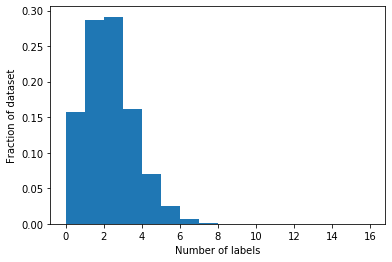

In [50]:
import matplotlib.pyplot as plt

def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [66]:
probs_train = label_model.predict_proba(L=L_train)

We see that around half of our train dataset data points have 2 or fewer labels from LFs. Fortunately, the signal we do have can be used to train a classifier over the comment text directly, allowing it to generalize beyond what we've specified via our LFs.

# Label Model

In [51]:
# Compared against Y_test - actual values of L
L_test = applier.apply(df_ts.rdd)

In this section we use LabelModel presented by spark which (as documentation) claims to produce probablity-aware labels to train the further classification model. However, comparison between Label Model and Majority Vote is also provided.

In [52]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter(cardinality = 3)
preds_train = majority_model.predict(L = L_train)

majority_acc = majority_model.score(L = L_test, Y = Y_test, tie_break_policy = "random")["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

Majority Vote Accuracy:   70.5%


In [53]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality = 3, verbose = True)
label_model.fit(L_train, n_epochs = 100, log_freq = 100, seed = 11)

label_model_acc = label_model.score(L = L_test, Y = Y_test, tie_break_policy = "random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     70.6%


From the above Label Model performs better in labelling test split. (NOTE from Max - n_epochs affect Label model). Cardinality = number of labels.

# Training a classifier with Scikit

We are training our classifier with Scikit-Learn, following successful classification examples from the Snorkle documentation. We tried using  MLlib which supports two linear methods for classification: linear Support Vector Machines (SVMs) and logistic regression. However, as Linear SVMs supports only binary classification, logistic regression would be the only suitable option for a multiclass classification problems like ours. We ran into issues with our selected MLlib Multiclass classifier ("LogisticRegressionWithLBFGS") not accepting our input, even after data conversions. Thus, we switch to Scikit and also focus on a linear regression.

### Data Preparation

In [54]:
# Import models 
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [89]:
# convert Spark train dataframe to Pandas dataframe to proceed
pandas_df_tr = df_tr.select("*").toPandas()

In [100]:
# convert Spark test dataframe to Pandas dataframe to proceed
pandas_df_ts = df_ts.select("*").toPandas()

In [90]:
# check dataframe before proceeding
pandas_df_tr.head(5)

,title,des_stemmed
0,coconutcoriander chutney,simpl prepar incred flavour take minut prepar ...
1,curd rice,curd rice yoghurt rice indian favourit easi cu...
2,indian khichri,khichri popular easi dish northern region indi...
3,kheer,popular pakistani rice pud flavour cardamon ro...
4,madras potato curry,dish make colour main dinner parti potato caul...


We decide to merge the two columns to unify the following work, namely filtering out unlabeled data points, featurization and classification


**Train Dataframe Changes:**

In [92]:
# merge the two existing columns into one
pandas_df_tr['title_description_merged'] = pandas_df_tr[['title', 'des_stemmed']].agg(' '.join, axis = 1)

In [97]:
# Drop old columns
pandas_df_tr.drop(columns = ['title', 'des_stemmed'], inplace = True)
pandas_df_tr.sample(5)

,title_description_merged
509,smoky eggplant and yogurt salad pure eggplant ...
2137,pico de gallo fresh tomato salsa made red onio...
855,chicken and ricotta lasagne great chicken take...
846,chicken wrapped in parma ham with pizzaiola sa...
817,spaghetti aglio e olio say box spaghetti toss ...


**Test Dataframe Changes:**

In [102]:
# merge the two existing columns into one
pandas_df_ts['title_description_merged'] = pandas_df_ts[['title', 'des_stemmed']].agg(' '.join, axis = 1)

In [103]:
# Drop a selection of old columns (not the label)
pandas_df_ts.drop(columns = ['title', 'des_stemmed'], inplace = True)
pandas_df_ts.sample(5)

,num_label,title_description_merged
402,1,baked sweet peaches stuffed with figs and pine...
145,0,carrot soup indienne i carrot featur creami cu...
550,2,cheesy nacho chilli mexican style dish tasti c...
131,0,beet and yogurt salad dish consist slice beet ...
283,1,tomato and basil salad simpl salad perfect gri...


### Filtering out unlabeled data points

To improve performance because of missing labels in some LFs, we filter them out using a module from the Snorkel library:

In [98]:
# Importing the library and filtering out unlabeled data points

from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X = pandas_df_tr, y = probs_train, L = L_train
)

### Featurization

As suggested in the Snorkel Tutorial, we implement "bag of n-grams" for simplicity and performance reasons.

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range = (1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.title_description_merged.tolist())
X_test = vectorizer.transform(pandas_df_ts.title_description_merged.tolist())

### Classification

In [ ]:
# Statistics by class
labels = data.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

In [108]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [111]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C = 1e3, solver = "liblinear")
sklearn_model.fit(X = X_train, y = preds_train_filtered)

LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Analysis of results

**Accuracy**

In [145]:
# print accuracy of model
print(f"Test Accuracy: {sklearn_model.score(X = X_test, y = Y_test) * 100:.1f}%")

Test Accuracy: 80.9%


In [143]:
# print further model results (scores)

from sklearn.metrics import classification_report

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       276
           1       0.84      0.86      0.85       240
           2       0.69      0.92      0.79       229

    accuracy                           0.81       745
   macro avg       0.83      0.82      0.81       745
weighted avg       0.84      0.81      0.81       745



We learn that the model yields a weighted average precision score of 81 (same as the f-score). The numbers show that on the hold-out set, the model correctly produces the following results as shows in the confusion matrix: 

**Confusion Matrix**

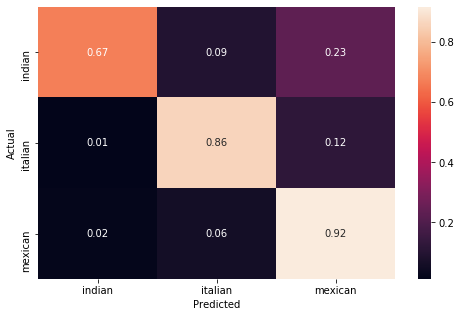

In [141]:
# Produce confusion matrix with seaborn library

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, predictions)
cmn = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8, 5))
target_names = ["indian", "italian", "mexican"]
sns.heatmap(cmn, annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

The confusion matrix shows us in detail the solid performance of the classifier. About 67% of indian dishes were correctly classified, respectively 86% for italian and – overall best and impressively – 92% correctly for mexixan. The largest error rate can be observed for 23% indian dishes being classified as mexican, indicating a culinary similiarity between those two cuisines. Conversely, the italian and indian cuisine are the two most distinct cuisines. 

### Conclusion

After building and running the classifier we see a steady increease in test accuracy to ca. 
81%. As suggested by the documentation, this is because the generalization of the classifier, going fruther than the labeling functions which we built before. With the confusion matrix we were able to understand how the cuisines are different from each other – and which implications this has if a data scientist and a Product Team wanted to autonomously label user generated content.